In [3]:
import os
#os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES']="3,4,5"
import torch,torchvision
import matplotlib
from PIL import Image
from torchvision import transforms
from torch import nn
import numpy as np
import segmentation_models_pytorch as smp
import cv2
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import glob
import pandas as pd
import time
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline


In [6]:
G = torch.load('G_pix2pix_BF2Cy5').module

In [7]:
G = tor

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [1]:

#torch.manual_seed(0)
#random.seed(0)
#np.random.seed(0)

model_smp = smp.Unet(
    encoder_name='resnet34',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None, 
    encoder_depth = 4, 
    decoder_channels = [384,192,81,27],# use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(2, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 2, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        
root_path = '/mnt/sdc/cell_images/data/Project_4/Astrocytes/'
folders = glob.glob(root_path+"*/")
folders.sort()

In [2]:
df_overall = []
for i in range(4):
    files = glob.glob(folders[i]+'/*.tif')
    df = pd.DataFrame(files)
    df.columns = ['Path']
    df_spt = df['Path'].str.split(r'/|\.| |\(|\)',expand = True)
    col_len = len(df_spt.columns)
    df['Folder'] =df_spt[7].str.strip()
    df['Row'] = df_spt[13].str.strip()
    df['Column'] = df_spt[15].str.strip()
    df['Field'] = df_spt[17].str.strip()
    df['Identification'] = df['Row'].str.cat(df[['Column', 'Field']], sep='-')
    df['Colour'] = df_spt[col_len - 5].str.strip()
    df['Channel'] = df_spt[col_len - 3].str.strip()
    df = df.sort_values(by = ['Folder','Identification','Colour'])
    df_overall.append(df)

df = pd.concat(df_overall)



In [3]:
df

Path  \
18772  /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
10005  /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
1782   /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
17051  /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
15424  /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
...                                                  ...   
18574  /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
18389  /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
13340  /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
5676   /mnt/sdc/cell_images/data/Project_4/Astrocytes...   
8090   /mnt/sdc/cell_images/data/Project_4/Astrocytes...   

                                          Folder Row Column Field  \
18772  190824_AstroPaint_20X_31_803_Astro_1_2019   C     10     1   
10005  190824_AstroPaint_20X_31_803_Astro_1_2019   C     10     1   
1782   190824_AstroPaint_20X_31_803_Astro_1_2019   C     10     1   
17051  190824_AstroPaint_20X_31_803_Astro_1_2019   C     10     1   
15424  190824_AstroPaint_20X_31_803_Astro_1_2019   C     10     1   
...                                          ...  ..    ...   ...   
18574  190824_AstroPaint_20X_34_803_Astro_4_2019   N      9     9   
18389  190824_AstroPaint_20X_34_803_Astro_4_2019   N      9     9   
13340  190824_AstroPaint_20X_34_803_Astro_4_2019   N      9     9   
5676   190824_AstroPaint_20X_34_803_Astro_4_2019   N      9     9   
8090   190824_AstroPaint_20X_34_803_Astro_4_2019   N      9     9   

      Identification          Colour Channel  
18772         C-10-1            Blue    FITC  
10005         C-10-1           Green   dsRed  
1782          C-10-1             Red     Cy5  
17051         C-10-1  TL-Brightfield   dsRed  
15424         C-10-1              UV    DAPI  
...              ...             ...     ...  
18574          N-9-9            Blue    FITC  
18389          N-9-9           Green   dsRed  
13340          N-9-9             Red     Cy5  
5676           N-9-9  TL-Brightfield   dsRed  
8090           N-9-9              UV    DAPI  

[76800 rows x 8 columns]

In [4]:
class Pix2pixDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None,mode = "train"):
        self.dataframe = dataframe
        self.transform = transform
        self.mode = mode
    def __len__(self):
        length = int(len(self.dataframe)/5)
        return length
    
    def __getitem__(self, index):
        row_FITC = self.dataframe.iloc[index*5]
        row_dsRed = self.dataframe.iloc[index*5+1]
        row_Cy5 = self.dataframe.iloc[index*5+2]
        row_BF = self.dataframe.iloc[index*5+3]
        row_DAPI = self.dataframe.iloc[index*5+4]

        image = Image.open(row_BF["Path"])
        pre_transform = transforms.ToTensor()
        #img_FITC = pre_transform(Image.open(row_FITC["Path"]))
        #img_dsRed = pre_transform(Image.open(row_dsRed["Path"]))
        img_Cy5 = pre_transform(Image.open(row_Cy5["Path"]))
        #img_DAPI = pre_transform(Image.open(row_DAPI["Path"]))
        
        label = torch.stack([img_Cy5],dim = 1)
        
        label = label.squeeze(0)

        # Resize
        #resize = transforms.Resize(size=(512, 512))
        #image,label  = resize(image),resize(label)
        #mask is already 512*512
        #mask = resize(mask)

        return image,label

In [5]:
#Rough normalization on val set, how could we give better normalization?
mean_BF = torch.tensor([2355.3508])
std_BF = torch.tensor([353.2483])
mean_label = torch.tensor([2185.792])
std_label = torch.tensor([2148.2190])

In [6]:
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None, mode = "train"):
        self.subset = subset
        self.transform = transform
        self.mode = mode
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, index):
        image, label = self.subset[index]
        pre_transform = transforms.ToTensor()
        image = pre_transform(image)
        resize = transforms.Resize(size=(600, 600))
        image,label  = resize(image).float(),resize(label).float()
        if self.mode =="train":
                    # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(
                image, output_size=(512, 512))
            image = TF.crop(image, i, j, h, w)
            label = TF.crop(label, i, j, h, w)

            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)

            # Random vertical flipping
            if random.random() > 0.5:
                image = TF.vflip(image)
                label = TF.vflip(label)
            
        post_transform_image = transforms.Compose([transforms.CenterCrop(512),
                                            transforms.Normalize(mean_BF,std_BF)
                                                  ])
        post_transform_label = transforms.Compose([transforms.CenterCrop(512),
                                            transforms.Normalize(mean_label,std_label)])
        image = post_transform_image(image)
        label = post_transform_label(label)
        return image,label

In [7]:
dataset = Pix2pixDataset(df)

In [8]:
n = len(dataset)
n_train = int(0.9*n)
n_val = int(0.05*n)
n_test = n-n_train-n_val

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])

train_data = DatasetFromSubset(train_set,mode = "train")
val_data = DatasetFromSubset(val_set, mode = "val")
test_data = DatasetFromSubset(test_set,mode = "val")

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4,shuffle=True,pin_memory = True)  # <1>
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4,shuffle=True,pin_memory = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4,shuffle=True,pin_memory = True)

In [9]:
to_image = transforms.ToPILImage()
inv_normalize_BF = transforms.Normalize(
    mean=[-2355.3508/353.2483],
    std=[1/353.2483]
)
inv_normalize_label = transforms.Normalize(
    mean=-mean_label/std_label,
    std = 1/std_label
)

In [10]:
G = model_smp
D = discriminator()
#G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G = torch.nn.DataParallel(G)
G = G.cuda()
D = torch.nn.DataParallel(D)
D = D.cuda()
BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-5, betas=(0.5, 0.999))

In [11]:
len(test_data)

768

/mnt/sdd/MSc_projects/yizhang/venvs/torch3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


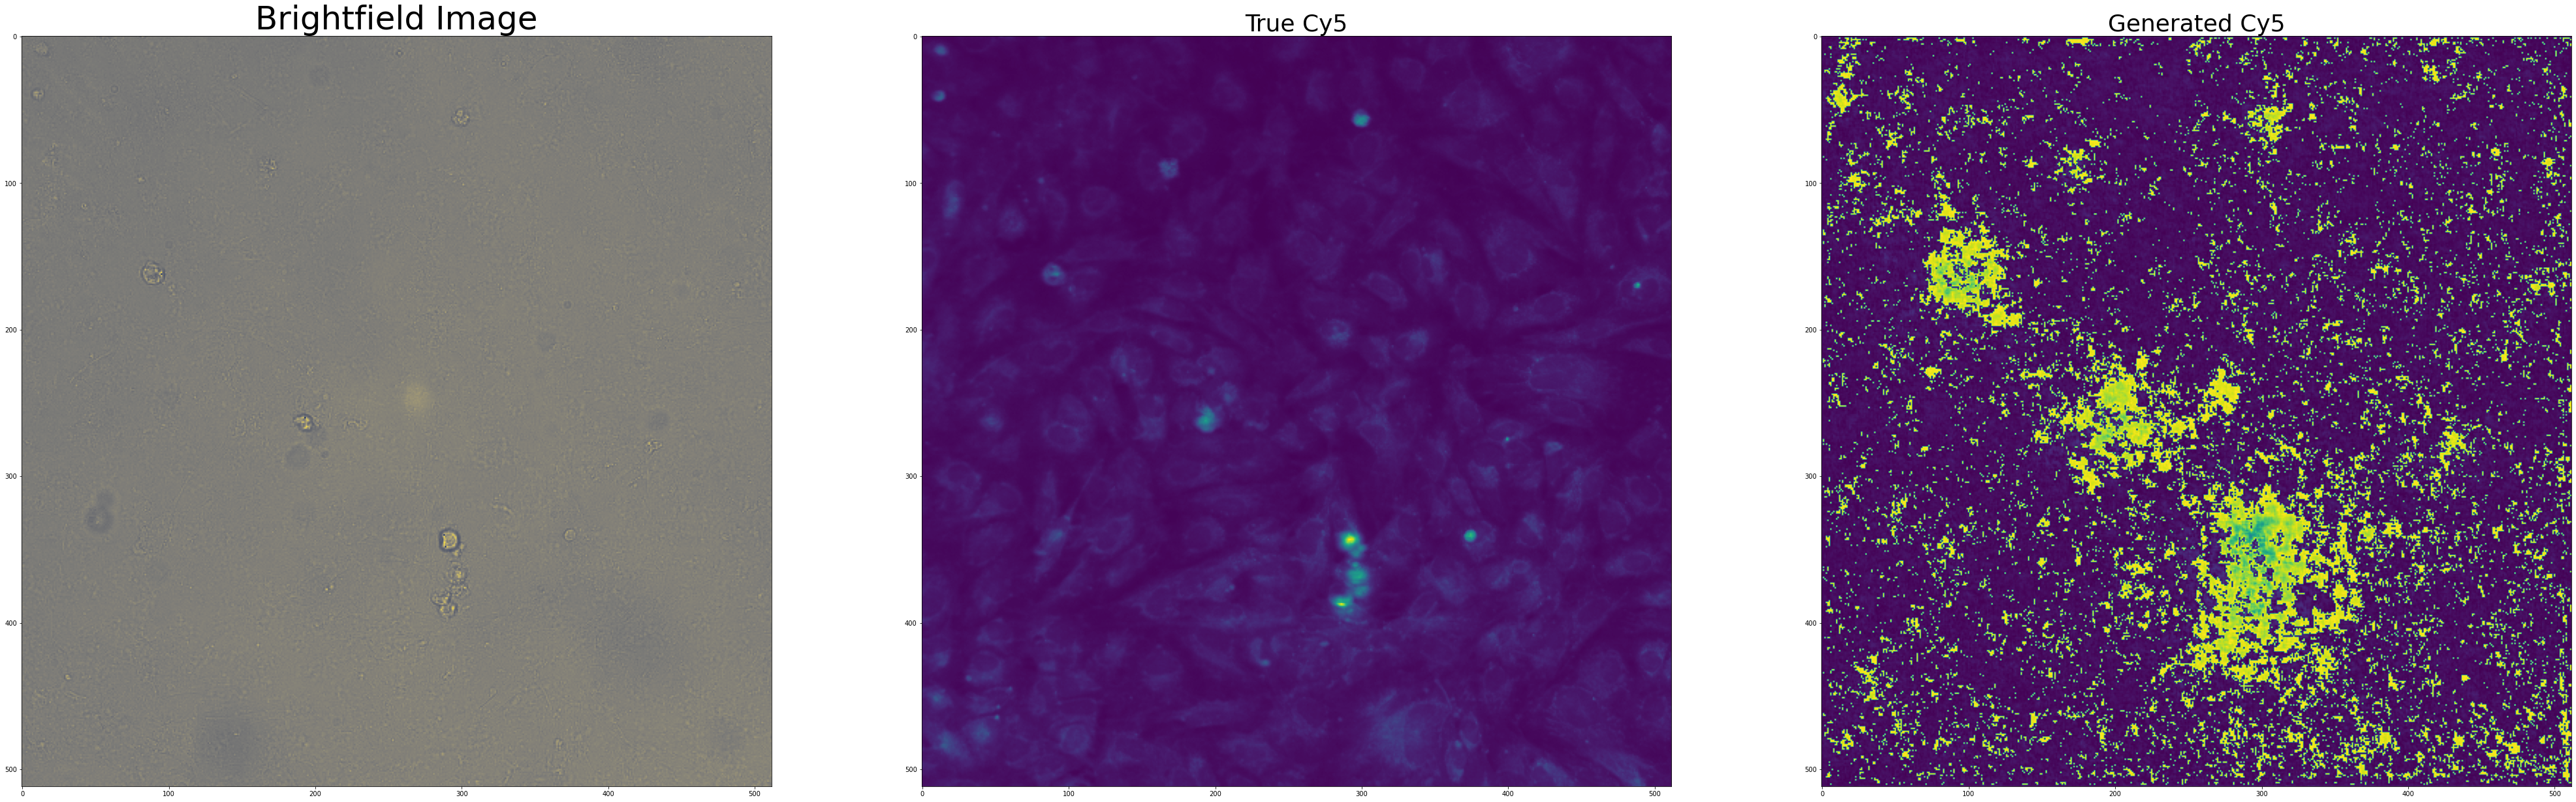

In [12]:
x ,y = test_data[13]
title = ["Cy5"]
with torch.no_grad():
    inv_y = inv_normalize_label(y)
    fig, ax = plt.subplots(2,5,gridspec_kw={'width_ratios': [1, 1, 1,1,1]},figsize=(70, 25))
    #plt.tight_layout()
    #ax1 = plt.subplot2grid((2,5),(0,0),rowspan = 2)
    plt.subplot(1,3,1)
    plt.title("Brightfield Image",fontsize=50)
    plt.imshow(to_image(10*inv_normalize_BF(x).type(torch.int16).squeeze(0)+10000),cmap = 'cividis')
    for i in range(1):
        plt.subplot(1,3,2)
        plt.title('True '+title[i],fontsize=36)
        plt.imshow(to_image(inv_y[i].type(torch.int16).squeeze(0)))
    for i in range(1):
        plt.subplot(1,3,3)
        plt.title('Generated '+title[i],fontsize=36)
        plt.imshow(to_image(inv_normalize_label(G(x.unsqueeze(0).cuda()).squeeze(0))[i].type(torch.int16)))
plt.savefig('/mnt/sdd/MSc_projects/yizhang/projects/project_test/BF2Cy5_pix2pix/Plot at epoch 0_test')

In [13]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

In [14]:
start_n_iter = 0
start_epoch = 0

In [ ]:
for epoch in range(start_epoch+1, 100):
    # set models to train mode
    D_losses = []
    G_losses = []
    G.train()
    D.train()
    print(epoch)
    pbar = tqdm(enumerate(train_loader),
                total=len(train_loader),bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    x_test,y_test = test_data[13]
    inv_y = inv_normalize_label(y_test)
    start_time = time.time()
    
    for i, data in pbar:  
        imgs , labels = data
        x = imgs.cuda()
        y = labels.cuda()
        prepare_time = start_time-time.time()
        #print('iteration '+str(i))
        #D first
        D.zero_grad()
        D_result = D(x,y)
        D_real_loss = BCE_loss(D_result, torch.ones(D_result.size()).cuda())
        G_result = G(x)
        D_result = D(x, G_result)
        D_fake_loss = BCE_loss(D_result, torch.zeros(D_result.size()).cuda())
        D_train_loss = (D_real_loss + D_fake_loss) * 0.5
        D_train_loss.backward()
        D_optimizer.step()
        
        train_hist['D_losses'].append(D_train_loss.data)
        D_losses.append(D_train_loss.data)
        #G then
        G.zero_grad()
        G_result = G(x)
        D_result = D(x, G_result).squeeze()
        G_train_loss = BCE_loss(D_result,torch.ones(D_result.size()).cuda())+ 100 * L1_loss(G_result, y)
        G_train_loss.backward()
        G_optimizer.step()
        train_hist['G_losses'].append(G_train_loss.data)
        G_losses.append(G_train_loss.data)
        
        if i%50 == 0:
            #print('Plot at epoch '+str(epoch+1)+' steps '+str(i))
            #show sample image for specific steps
            with torch.no_grad():
                fig, ax = plt.subplots(2,5,gridspec_kw={'width_ratios': [1, 1, 1,1,1]},figsize=(70, 25))
                #plt.tight_layout()
                #ax1 = plt.subplot2grid((2,5),(0,0),rowspan = 2)
                plt.subplot(1,3,1)
                plt.title("Brightfield Image",fontsize=50)
                plt.imshow(to_image(10*inv_normalize_BF(x_test).type(torch.int16).squeeze(0)+10000),cmap = 'cividis')
                for j in range(1):
                    plt.subplot(1,3,2)
                    plt.title('True '+title[j],fontsize=36)
                    plt.imshow(to_image(inv_y[j].type(torch.int16).squeeze(0)))
                for j in range(1):
                    plt.subplot(1,3,3)
                    plt.title('Generated '+title[j],fontsize=36)
                    plt.imshow(to_image(inv_normalize_label(G(x_test.unsqueeze(0).cuda())).squeeze(0)[j].type(torch.int16)))
                plt.savefig('/mnt/sdd/MSc_projects/yizhang/projects/project_test/BF2Cy5_pix2pix/'+'Plot at epoch '+str(epoch)+' steps '+str(i))
                



        # compute computation time and *compute_efficiency*
        process_time = start_time-time.time()-prepare_time
        compute_efficiency = process_time/(process_time+prepare_time)
        pbar.set_description(
            f'Compute efficiency: {compute_efficiency:.4f}, ' 
            f'Dloss:{D_train_loss.item():.4f}, Gloss: {G_train_loss.item():.4f},  epoch: {epoch}/{30}')
        
    epoch_time = time.time()
    per_epoch_ptime = epoch_time-start_time
    print(per_epoch_ptime)
    torch.save(G,'G_pix2pix_BF2Cy5')
    torch.save(D,'D_pix2pix_BF2Cy5')


1


/tmp/ipykernel_38731/2195272887.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(enumerate(train_loader),


  0%|          | 0/3456 [00:00<?, ?it/s]

/mnt/sdd/MSc_projects/yizhang/venvs/torch3.9/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_38731/2195272887.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2,5,gridspec_kw={'width_ratios': [1, 1, 1,1,1]},figsize=(70, 25))


4399.746445894241
2


  0%|          | 0/3456 [00:00<?, ?it/s]

4008.8049590587616
3


  0%|          | 0/3456 [00:00<?, ?it/s]